## data読み込み

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random
import seaborn as sns

random_state = 623

In [161]:
def load_file(files,Soldiers):
    """ファイルを読み込んでnumpy.arrayに変換する関数
    
    Args:
    files : 読み込むファイルのリスト
    Soldiers : セーラー戦士のリスト
    
    Returns:
    np.array(file_list) : 読み込んだ画像のnumpy.array
    y : 正解ラベル
    """
    file_list = []
    y=[]
    for file in files:
        # 正解ラベルをリストに代入
        for i,soldier in enumerate(Soldiers):
            if soldier in file:
                y.append(i)
                
        # load img
        f = cv2.imread(file)
        f = cv2.resize(f, dsize=(128, 128))
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        
        file_list.append(f)
    return np.array(file_list),y

In [162]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Soldiers = ["Sailorjupiter","Sailormars","Sailormercury","Sailormoon","Sailorneptune",
            "Sailorpluto","Sailorsaturn","Sailortibimoon","Sailoruranus","Sailorvenus"]

train_path = "./train/"
test_path = "./test/"
# load data
train,y_train = load_file(glob.glob(train_path+"/*"),Soldiers)
test,y_test = load_file(glob.glob(test_path+"/*"),Soldiers)

train = train.reshape((train.shape[0], 128, 128, 3)) / 255
x_test = test.reshape((test.shape[0], 128, 128, 3)) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train, x_valid, y_train, y_valid = train_test_split(
    train, y_train,test_size=0.2,random_state=random_state)

In [163]:
# train,valid,testのshapeを確認
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(640, 128, 128, 3)
(640, 10)
(160, 128, 128, 3)
(160, 10)
(200, 128, 128, 3)
(200, 10)


## 転移学習モデルを生成

In [6]:
import keras
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input

# base model(Xception)を読み込み
# include_top : 出力層側の3つのDenseを含むかどうか
base_model =  tf.keras.applications.xception.Xception(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

# base modelに出力層を追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
prediction=Dense(10,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"]
)

## 学習

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_datagen=ImageDataGenerator(
    width_shift_range=0.4, # 左にシフトする割合
    height_shift_range=0.4, # 垂直方向にシフトする割合
    rotation_range=30, # ランダムに30度の範囲で回転
    shear_range=0.2, # 反時計回りの回転
    zoom_range=0.2, # 拡大
    horizontal_flip=True) # 水平方向に反転

validation_datagen=ImageDataGenerator()

train_datagen.fit(x_train)
validation_datagen.fit(x_valid)

train_generator=train_datagen.flow(
    x_train,y_train,
    batch_size=70,
    shuffle=True
)

validation_generator=validation_datagen.flow(
    x_valid,y_valid,
    batch_size=70,
    shuffle=True
)

early_stopping = EarlyStopping(patience=70, verbose=1)

hist=model.fit_generator(train_generator,
                         epochs=300,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[early_stopping])

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
10/10 [==============================] - 12s 576ms/step - loss: 2.3452 - accuracy: 0.1152 - val_loss: 2.3200 - val_accuracy: 0.1063
Epoch 2/300
10/10 [==============================] - 4s 353ms/step - loss: 2.3026 - accuracy: 0.0911 - val_loss: 2.3105 - val_accuracy: 0.0812
Epoch 3/300
10/10 [==============================] - 4s 352ms/step - loss: 2.3014 - accuracy: 0.1150 - val_loss: 2.3112 - val_accuracy: 0.0812
Epoch 4/300
10/10 [==============================] - 4s 339ms/step - loss: 2.3014 - accuracy: 0.1228 - val_loss: 2.3139 - val_accuracy: 0.0812
Epoch 5/300
10/10 [==============================] - 4s 336ms/step - loss: 2.3004 - accuracy: 0.1234 - val_loss: 2.3200 - val_accuracy: 0.0938
Epoch 6/300
10/10 [==============================] - 4s 353ms/step - loss: 2.2991 - accuracy: 0.0968 - val_loss: 2.3437 - val_accuracy: 0.0688
Epoch 7/300
10/10 [==============================] - 4s 357ms/step - loss: 2.3002 - accuracy: 0.1318 - val_loss: 2.4598 - val_accuracy: 0.068

Epoch 58/300
10/10 [==============================] - 4s 337ms/step - loss: 0.5157 - accuracy: 0.8392 - val_loss: 3.9616 - val_accuracy: 0.5688
Epoch 59/300
10/10 [==============================] - 4s 336ms/step - loss: 0.4876 - accuracy: 0.8457 - val_loss: 2.8740 - val_accuracy: 0.6250
Epoch 60/300
10/10 [==============================] - 4s 342ms/step - loss: 0.4387 - accuracy: 0.8730 - val_loss: 1.6540 - val_accuracy: 0.7563
Epoch 61/300
10/10 [==============================] - 4s 341ms/step - loss: 0.3421 - accuracy: 0.8762 - val_loss: 6.4172 - val_accuracy: 0.5188
Epoch 62/300
10/10 [==============================] - 4s 347ms/step - loss: 0.4862 - accuracy: 0.8397 - val_loss: 46.4308 - val_accuracy: 0.2875
Epoch 63/300
10/10 [==============================] - 4s 336ms/step - loss: 0.3911 - accuracy: 0.8857 - val_loss: 21.3072 - val_accuracy: 0.2875
Epoch 64/300
10/10 [==============================] - 4s 342ms/step - loss: 0.3970 - accuracy: 0.8625 - val_loss: 5.0521 - val_accurac

Epoch 115/300
10/10 [==============================] - 4s 340ms/step - loss: 0.2860 - accuracy: 0.9132 - val_loss: 1.5694 - val_accuracy: 0.7875
Epoch 116/300
10/10 [==============================] - 3s 369ms/step - loss: 0.2783 - accuracy: 0.9266 - val_loss: 0.8429 - val_accuracy: 0.7875
Epoch 117/300
10/10 [==============================] - 4s 378ms/step - loss: 0.2729 - accuracy: 0.9217 - val_loss: 0.8787 - val_accuracy: 0.7750
Epoch 118/300
10/10 [==============================] - 4s 346ms/step - loss: 0.1926 - accuracy: 0.9555 - val_loss: 1.5984 - val_accuracy: 0.6875
Epoch 119/300
10/10 [==============================] - 4s 341ms/step - loss: 0.2781 - accuracy: 0.9157 - val_loss: 1.0906 - val_accuracy: 0.7875
Epoch 120/300
10/10 [==============================] - 4s 343ms/step - loss: 0.2518 - accuracy: 0.9274 - val_loss: 0.7738 - val_accuracy: 0.8250
Epoch 121/300
10/10 [==============================] - 4s 341ms/step - loss: 0.2495 - accuracy: 0.9271 - val_loss: 0.8228 - val_ac

## 正解率, 損失関数を確認

In [8]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
def plot_acc(history):
    """エポックごとの正解率をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,len(history.history["accuracy"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

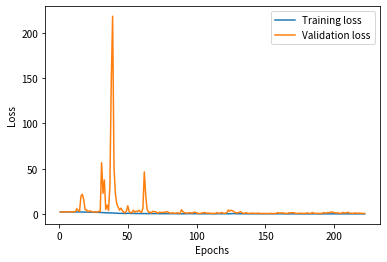

In [9]:
# 損失関数の描画
plot_loss(hist)

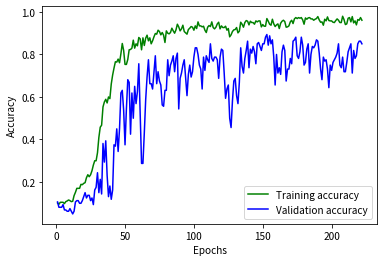

In [10]:
# 正解率を描画
plot_acc(hist)

## テストデータによる評価

In [39]:
# modelの評価
test_datagen=ImageDataGenerator()
test_datagen.fit(x_test)
test_generator=test_datagen.flow(
    x_test,y_test,
    batch_size=100,
    shuffle=False
)

scores = model.evaluate(test_generator)
prediction = model.predict(test_generator)
prediction_label = np.argmax(model.predict(test_generator),axis=1)

2/2 [==============================] - 0s 96ms/step - loss: 0.8476 - accuracy: 0.8000


<ipython-input-182-b4449feba43f>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test = np.array(file_list)


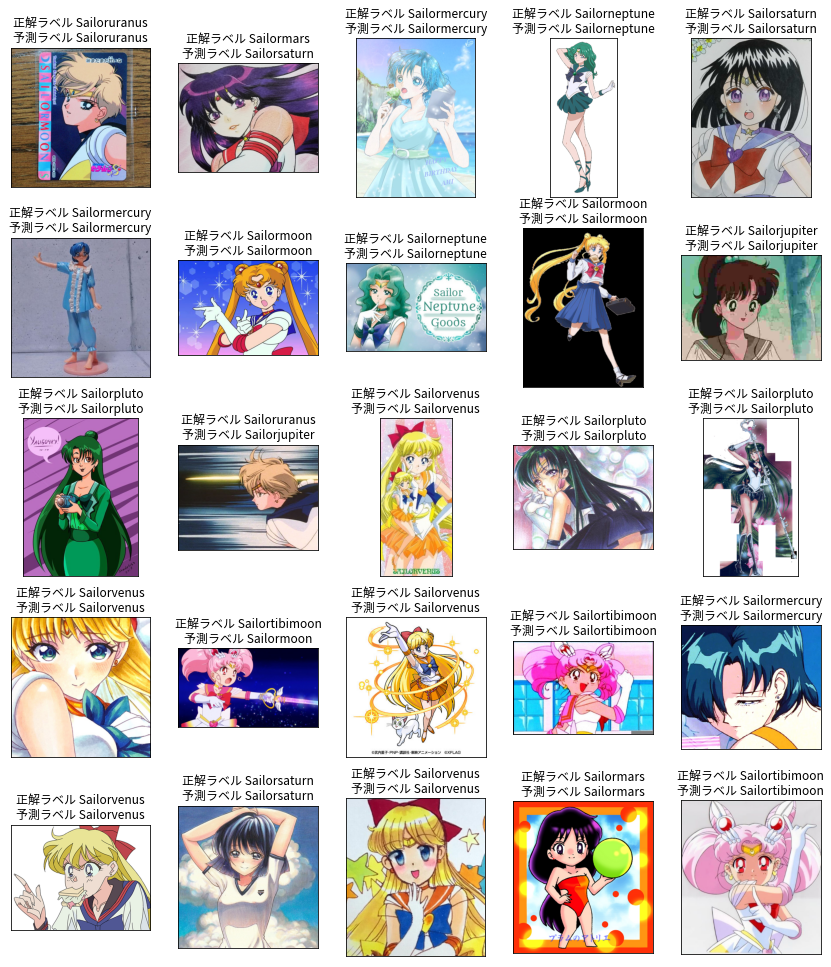

In [182]:
files=glob.glob(test_path+"/*")
file_list = []
y_label = []
for file in files:
    # 正解ラベルをリストに代入
    for i,soldier in enumerate(Soldiers):
        if soldier in file:
            y_label.append(i)
    # load img
    f = cv2.imread(file)
    f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
    file_list.append(f)
test = np.array(file_list)

r =np.array(random.sample(range(0,200),25)).reshape(5,5)

fig = plt.figure(figsize=(15, 15))
k=1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,k)
        plt.imshow(test[r[i][j]])
        k+=1
        plt.xticks([]),plt.yticks([])
        plt.title("正解ラベル "+Soldiers[y_label[r[i][j]]]+"\n予測ラベル "+Soldiers[prediction_label[r[i][j]]])
        
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
plt.show()

Text(0.5, 15.0, '予測ラベル')

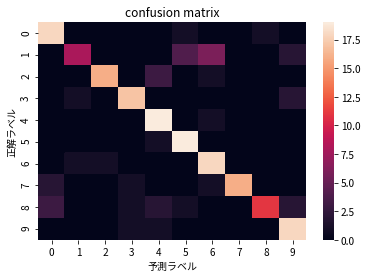

In [186]:
# 混同行列
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_label, prediction_label)
sns.heatmap(cm)
plt.title("confusion matrix")
plt.ylabel("正解ラベル")
plt.xlabel("予測ラベル")

In [104]:
from sklearn.metrics import classification_report

print(classification_report(y_label, prediction_label))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAWEAAAEICAYAAACOBEVFAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAAcfklEQVR4nO3deZRdZZnv8e8vCYEQghDmRBsISAARieCC0A0kyKDMiqsFri04UI1cUG5s70Ux6EKknS4XBVQiSAAZbBExTDLI0IAxkkBIAxKZhUQIQ4IhpIGqeu4fexceizpjnb33OZvfx7XXOue8e+/nPWV46q13v4MiAjMzK8aIoitgZvZ25iRsZlYgJ2EzswI5CZuZFchJ2MysQE7CZmYFchK2t5B0jKSlku6RpBau/1dJF2VRtzxIulhST9H1sLcHeZywDSbpBeAk4JcRsbrg6rSVpPOAuRExu+i6mIFbwja0DYC7y5aAU+OLroBZJSfhLidpgqQrJb0k6UFJ+6efj5d0qaQXJf1R0uEV13xd0umSzpH0nKSFkialZX9KT3tQ0qlp18TtFde++V7SSEnnSVou6TFJx1fcf3bFNXtKWiBphaTrJP1DRdmTkj4s6fa0fNZQXSBp+Sck3SJpmaRTJL1f0tz0O/ZUnLtvet7Az2SX9POrgY8C50l6RdJW6feZJekMSc9L2iKNdYyk0ZIelnRYev1+kh6QNGp4/6+Z/Y2TcBeTNBL4FbAUeBdwJPBMWnwhsBr4B+DTwCxJO1dcfjzwm/S6pcAXASJim7R8+4g4rU4VPgQcCmwH7AU8PEQd3wX8GpgJbAosAK5O6z7gS8AngR3Tuu5SJd7/Aj4LHAJ8Azg1jf8/ge9VJMfxwFeBTYD/AM5Ov9thwJ3Av0bEOhHxWHr+x0l+Vu8EnhoIFhGvA58HvitpTeB0YEZE9Nb5uZg1zL/Ru9sUYCtgjzRhLAKQtDFwEDA+IlYBc9MHZZ8mSYIAcyLi2vT8m4EPtxB/KbAuSfK8OSKeGeKcI4HfRsT1aazTgOOA9wP3pOecFhF/TssfBN5dUVbp7Ih4UtJTwF+BsyJimaQbgXHAxsDSiPh52preClgJ7NTA9/hmRPSndXizICJukvQAcBXwfETcVOdeZk1xS7i7TQIeTxNwpS1IEsbLFZ89AmxZ5T7LgdHNBo+I+4D9ga8A8yTtMcRpWwCPVlzTCzwxnLpE8jR5RcX75enL0QCSpgPzgHNIEvNadb7KcwMJuIrLgAOA8+rcx6xpTsLd7Wlg8yH6KJ8CNpQ0ruKzScCTLcR4A1i/4n1lNwIRcWdETCNJeDdIGpzwnqIi4abdEJu3WJe6JK1B0v1xXER8CPjxEKc1/O8+vd9M4AzgZEn+b8bayv+gutt84AXgm5LGSJosaT9gGXAjSV/mGEkfAD4FzG4hxuPA9pK2lLQjad8xgKSDJB2eJt4XgDUZlKSBnwP7S9o/7Vc9BXgOuLeFujRibZKuifUlrUcy1K7Ss8BUSWsM6peu5njgPpI+ZpH8HM3axkm4i0XEGyQPqXYiSS5XAWulf64fDawHLAF+BhwfEX9oIczvgcuB+4Fvk7QKBzxOkpSWAj8CPp32QVfW8UngI+m1y4CpwKFZPdxKu2BOJXlgeWt6VHbXnAnsQ/JXxE617pX2rX8F+Fr6M/088O+SNmh/ze3typM1zMwK5JawmVmBnITNzArkJGxmViAnYTOzAmU+Y+61h+/I5cnf2B2PyiOMtcn6Y9bJJc7y1a/kEidvef38IN+fYe/rS5peOnWwN154vOGcs8aGk4Ydb7jcEjYzK5DXjjCzcunvK7oGTXESNrNy6euuRe6chM2sVGqvxdR5nITNrFz6nYTNzIrjlrCZWYH8YM7MrEBlbQlLGk+yqcHyuiebmRUkumx0RM3JGpI2l3SVpL8AdwMPSFqV7u67eT5VNDNrQn9/40cHqDdj7jLgJ8DEiNguIiaS7Jh7cVo2JEk9kuZLmn/+f1zTvtqamdUT/Y0fHaBed8S6wG2VmyBGxEpJtwDfrHZRRMwCZkF+a0eYmQGlezD3A5IuiPnAYpKW87Yk28KckW3VzMxa0CEt3EbV7I6IiJ+Q7Al2DbASeJlk766pEXFh9tUzM2tSX2/jRwMknSzpWUknSVpb0sKKY5mk0wadv4WkVyvO+XKt+9cdHRERzwOXNlRbM7Oitf+B2xxgEkBEvEq6QWy6y/htwPeHuGZeRExv5OYeJ2xmpRLR3j7hiHhI0tIhio4DLo2IF4coe6nR+3s9YTMrlxxGR0gS8Amq9xK8Lx0h9ltJ29a6l5OwmZVLE+OEK4fTpkdPg1G2BF6pMnntaeAoYHfgZuDcWjdyd4SZlUsTLdzK4bRNmgI8UOWefcAfACTNAk6sdSO3hM2sXPreaPxo3URg2cAbSRtKmiNplKRD0vcCDgPm17qRW8JmVi5tHB0haQJwPclM4T5JB0fEB4F1gNUVp44FdgBGAyuAq4BNgL8AR9eMEZHthLZRoyfmMmPu8g2m5REGgCNfvD23WGV18KbvzyXOe0aMyyUOwLeW3pFbrDxtvd6E3GI9vOyeYe9+/N9zL28456w19cjCd1t2S9jMyqVDFuZplJOwmZWLk7CZWXFieA/ccuckbGbl0mUL+DgJm1m5uDvCzKxAbgmbmRXILWEzswK9XVrCkm6OiH3bWRkzs2Hr7a7dlmsmYUmfr1ZEss2RmVlnKVlL+MvAr0nmPw82stpF6XJwPQAa+Q5GjBjbcgXNzJpSsj7hs4A5EfHHwQWSDqt2UeXycHmtHWFmBpSrJRwR365RfECb62JmNnwlawlXFRFDdVGYmRWrTC1hM7OuU6bREWZmXSfjNdLbzUnYzMrl7dInbGbWkZyEzcwK5AdzZmYF6usrugZNKU0SznPzzZU/PzG3WOM+fnZusaZulN9M9GuevTeXOHeNWSeXOGX26IqlRVehOW3ujpB0MnAS8K2IOEvS14HPAi+kp/yPiHhw0DXHAl8AVgJHRcQT1e5fmiRsZgZk0Sc8B5g06LNTIuKioU6WtDFwMrAjsBdwJvCRajcf0aZKmpl1huhv/GjkdhEPAYP/HHipxiX7AQsiYhVwI7C7pKq51knYzEol+qPhQ1KPpPkVR0+DYb4k6UFJP5A0uEdhM2AxQET0ASuA8dVu5O4IMyuXJrojKhcba8L5wIXAapJVJo8ELhl0TmUDdxxQdQaJk7CZlUvGoyMi4pmB15J+wVvXVl8K7JqWrwusDyyvdj93R5hZufT3N340SdKako6SNELSOsA+wHxJoyTNkbQhcBMwRdJYYBpwQ0T1Dmi3hM2sXNo4OkLSBOB6YFOgDzgUuA2YB2wCXAFcDYwBdgDGRsRTks5Iz1kJHFUrhpOwmZVLGxfwiYilwE5DFJ026P2rVAxji4gLgAsaiTGcjT4nRcTjrV5vZpaJLls7omafsKQtJV0q6T8lnSVpy4riKzOum5lZ8/qj8aMD1Hsw9zPgd8CJwEPADZI+kZYpy4qZmbWkr6/xowPU645YOyLOTV/fL+kK4EpJ25OMkRuSd1s2s6JEmbojgP+StN/Am4j4K3AQsCXpOLihRMSsiNglInZxAjazXHVZd0S9lvDxJMMu3hQRr0s6Crgzs1qZmbWqTOsJR8QrwO+H+DyAH2ZVKTOzlnVIC7dRHidsZuXS2xkP3BrlJGxm5VKm7ggzs67j7ggzs+J02xA1J2EzKxe3hM3MCuQkXIz1c9xVN88dkF+57Tu5xVpn+v/OLVZelq9+pegqdL2t15tQdBWa0yHTkRtVmiRsZgbJHnPdxEnYzMrFSdjMrEAeHWFmViC3hM3MCuQkbGZWnOjrru4Ib3lvZuXS5vWEJZ0s6VlJJ6XvD5X0O0mLJX21yjW9khamR80xrW4Jm1mpZDBEbQ7pTsqSBGwL7AMEsFjSLyJi8aBrno6InRq5uZOwmZVLm5NwRDwkaWn6OoBvD5RJuhd4FzA4Cb/U6P2rdkdI2lbS+ZI+p8T3JD0q6RZJk5v7GmZmOelv/JDUI2l+xdHTaBhJawA7Av81RPEESXdLmitp91r3qdUSvgS4CNgOuB6YC+wMfAyYDUytUTlv9GlmhYjexh/MRcQsYFaLoY4Dbo2I54YoOwRYBBxOkku3qnaTWkl4TEScI2ljYAlwcET0AhdI+rdaNav8YqNGT+yu8SJm1t1yGBwhaX/gGGDaUOURcU963hXADyWNjojXhzq31uiIxyW9OyKWAR9MEzBpV8TS1qtvZpad6I+Gj1ZI+gDJHpsfjYiV6WejJM2RtKGkvSVtkZ4+HXiyWgKG2i3hE4BegIj4z4rP9wBOaqn2ZmZZa2NLWNIEku7YTYE+SQeT9AOvBq6SNBK4BTiVZGf6scAyYJakicBrwNG1YlRNwhHx5yqfn9/8VzEzy0c7h6hFxFJgpwZPn1Txer9GY3iImpmVS3dNmHMSNrNySZ5edQ8nYTMrlS7b8d5J2MxKxknYzKw4bgmbmRXISbggZd1VN88dkFcvvTO3WGMm7JFLnDx34S7rv8FHV3TX3KzoU9FVaEppkrCZGbglbGZWqOh3S9jMrDBuCZuZFSjCLWEzs8K4JWxmVqB+j44wMyuOH8yZmRWo25JwrZ013kLS9llVxMysHSIaPzpB1ZawpD0HfwScK+l4eMtuG2ZmHaHbWsK1uiOuAx4F7iNJwAAbA58CAqiahL3bspkVpUxD1LYFvgW8A/hiRDwpaW5EfKreTb3bspkVpa/LRkdU7ROOiCUR8S/Ad4GLJX0NP8gzsw4XoYaPRkg6WdKzkk5K328o6RZJD0qaWeWaYyU9IGmupC1r3b/ug7mI+D2wF/AU8FxDtTYzK0j0q+GjQXPSY8BM4GqSXZcPlPS+ypMlbQycDOwKfAM4s9bNGxodEYnZEXFQo7U2MytCu0dHRMRDQOV6ngcCt0ZEH3Bl+r7SfsCCiFgF3AjsLqlqrm1qiJqZWadrpiUsqUfS/Iqjp4EQGwGPpa+XABMGlW8GLAZIE/UKYHy1m7mP18xKpa+/8bZl5SCCJoi/jRgbRzJabLDKSlQ75y0nmpl1vRwmazwHbJ2+nszfd1WQvp8MIGldYH1gebWbOQmbWan0hxo+WnQtMF3SSJJBC9dJGiVpjqQNgZuAKZLGAtOAGyKqr+3m7ggzK5V2TtaQNAG4HtgU6JN0MPDPwBXAccDlEbFI0trADsDYiHhK0hnAPGAlcFStGE7CZlYq7VwTIiKWAjsNUbTvoPNeBSZVvL8AuKCRGE7C9qYJW304t1h57eyc167O1jmG0c1QCCdhMyuVZkZHdAInYTMrlW5brMZJ2MxKxd0RZmYFKtNSlmZmXafLNlt2EjazcgncEjYzK0xv2bsjJI2KiN4sKmNmNlzd1hKuOaBO0vcrXk+V9CiwTNK9kt6bee3MzJrU38TRCeqNaq6cbvQ9khXlNwC+BFyYVaXMzFoVqOGjEzTTHdEPXBkRAfxW0lrVTvRuy2ZWlE5p4TaqXhLeUdJjJGthTiDZU2mBpM1JVpQfkndbNrOi9HVIC7dRNZNwRFQrnwTMaH91zMyGp/H9OztDS0PUIuK2dlfEzKwd+svUEjYz6zbd1v/pJGxmpVK2B3NmZl2lX+6OMDMrTF/RFWiSk7CZlcrbYnSEmVmnatfoCEkzgE+mb0cA2wAbRMSqtHw2sCfw1/Sc6RGxvNk4pUrC649Zp+gqtN3y1a+UMlZeG3CuWnRZLnEAxu5Yc2dzy0m7RkdExJnAmQCSPgNMGEjAFT4VEXcMJ05pknAZE7CZNa/d3RHpEg0nALsNUfzScO/fXduSmpnV0cwqapJ6JM2vOHqGuOXBwG8i4rUhyv6vpD9K+mqr9S1NS9jMDKCviZZw5To3NRwM/HSIz08HVgJrArdLuiMi7mw8esJJ2MxKJYPJGlOABwZ/GBGPDryWdC2wLdB0EnZ3hJmVSgaLum8GvAgg6YuSjpA0XtJHlNgA+CdgQSv1dRI2s1IJNX40aGS6jjrAFsBEYDUwDZgP3AdcHBH3tlJfd0eYWam0uzsiItaveH1iRdEX2nF/J2EzKxVPWzYzK1C3TVuut9vySZImp6/3lLRI0lJJ8yTtnE8VzcwaV7bdlj8ZEYvT12eSTNGbAJwIzM6yYmZmrShbEo50U09INvb8U/r6IWp0vVTOQunvHzzV2swsO9HE0Qnq9Ql/AbhZ0t3AUmCOpEdIhmbMrHaRd1s2s6J0W59wvd2W75L0XmBfkvFxTwDPAF+JiBeyr56ZWXNKNzoiXbTi2hzqYmY2bP0d09HQGA9RM7NS6ZQHbo1yEjazUumudrCTsJmVjFvCZmYF6lV3tYWdhM2sVLorBTsJm1nJuDtikK3Xm5B1CAAeXbE0lzh5y3MD0zx3W87LO3cdasuwbKz8+Yn1T2qTcR8/O7dY3cZD1MzMCtRdKdhJ2MxKxt0RZmYF6uuytrCTsJmVSre1hL3Rp5mVSjTxv3ok9UpamB5nDyrbUNItkh6UVHVVyXrcEjazUmlzS/jpiNipStlM4GrgR8DdkuZExP3NBnBL2MxKpZ9o+GjASzXKDgRujYg+4Mr0fdOchM2sVNq8s8YESXdLmitp90FlGwGPpa+XAC1NiqjZHSFpTESsbuXGZmZF6G1idISkHqByRs+sdGegAYcAi4DDgUuArSovTw+AcbQ4RLleS/hFSV+RtEYrNzczy1szD+YiYlZE7FJxzPq7e0Xck25scQWwgaTRFcXPAVunryeTbAHXtHpJ+BHgWWCepG+m296Pr3fTyo0+V6x+vpV6mZm1pF27LUvaW9IW6dvpwJPARyXNSD+7FpguaSSwF3BdK/Wtl4T7IuKnwFTgPuAzwO2Snpf0YrWLKn+7rDdmo1bqZWbWkjYOUVsGzJL0IPBd4GhgIrBlWn46f+uuuDoiFrVS33pD1ARv7jN3ZXqYmXWsdg1Ri4gHgP0GfXx/RfmLJJsgD0u9JHzxcAOYmeWpL0o0bTki/l9eFTEzawcvZWlmVqBGpiN3EidhMyuVblvAx0nYzErF3RFmZgVyd4SZWYFKNTrCzKzbuDtikI3WWDfrEAA82tq0bauQ187YAC++9tdc4uS5g3SeOyA/OWVybrH2eWJlbrHawQ/mzMwK5D5hM7MCuTvCzKxA4QdzZmbF8Zb3ZmYFcneEmVmB3B1hZlYgt4TNzApU+iFqksYBo9NV5c3MOkq3TVuuucecpH+UdJekqyXtL+lU4A/AnyQdk0sNzcya0E80fHSCeht9/gQ4FvgIsDPJhp/vAbYFTql2UeVuy8+uWtKuupqZ1VW2JLwW8OdIHjfuCpwVEf3ACmBktYsqd1vedOzEtlXWzKyeiGj4qEXSOEmXSFooaa6krQaVf13SM2n5QknvaaW+9fqEzwSekPQ0cB7wWUlTgN2Am1oJaGaWpTa2cHcALo2I30g6AfgGcNSgc06JiIuGE6TeRp/nSLoQeCMiXpf0M+BQYAlw2XACm5lloV2jIyJibsXbu4AjhjjtpeHGqdcdQUSsiojX09evRsTlEXFJRPQNN7iZWbv1RX/DR+Xzq/ToqXLbXYF7h/j8S5IelPQDSS0N+fU4YTMrlWZmzEXELGBWrXMkrQvMAA4YVHQ+cCGwGvg1cCRwSTN1BSdhMyuZdo56kLQm8EvgjIh4rLIsIp6pOO8XJKPGmla3O8LMrJtEE/+rRdIIYDawYODhm6QjJM2QtKakoySNkLQOsA8wv5X6uiVsZqXS374Zc58jeRg3T9LC9LPLgXcCvcDWwDxgE+AK4OpWgjgJm1mptHF0xLnAuTVOOS09hsVJ2MxKpS+6a6vPzJPw3OcfzjqEtUleOyBDvrsgl9EW9y3OLdaqRd01JaCN3RG5cEvYzEql9EtZmpl1MreEzcwK5JawmVmB+rpsRQUnYTMrFW/0aWZWoE5ZrL1RTsJmViqlbQlLGj2wpKWZWafqttER9Tb63EjSTyX9BXhZ0pJ07cz/I2l0TnU0M2tYuxbwyUu9VdRmA9cAWwEfB74D7AGsDfw405qZmbWgmUXdO0G9JPxuYE5EvEqSjD8ZES9FxNeA91e7qHK1+v7+VW2srplZbe3a6DMv9fqEbwR+LekWYG/S7T0kbQO8UO2iytXqR42e2Bnf1MzeFrqtT7jeRp8nSvow8F7gYuBXadHjwL9kXDczs6Z1Sgu3UXVHR0TEDcANgz7rBf6SVaXMzFrlccJmZgUqXUvYzKybdMqoh0Y5CZtZqZTqwZyZWbfptu4Ib3lvZqXSzhlzko6V9ICkuZK2HFS2oaRb0lnEM1utr5OwmZVKuyZrSNoYOBnYFfgGcOagU2aSbHO/I3CgpPe1Ul8nYTMrlf6Iho869gMWRMQqkolru0uqzJkHArdGRB9wZfq+aZn3Cfe+vkStXCepJ515l6m84jhWd8Uq43cqc6xKzeQcST1AT8VHsyrqvBmwGCAi+iStAMbzt9nCGwGPpa+XAP/YSn07uSXcU/+UrorjWN0Vq4zfqcyxWhIRsyJil4pj8C+Nyhw5Dv6uI1npMVRZwzo5CZuZFWkpMBlA0rrA+sDyivLngK3T15PT85vmJGxmNrSbgCmSxgLTSJZv+GdJM9Lya4HpkkYCewHXtRKkk5NwXn1JefZZOVb3xCrjdypzrLaLiOeBM4B5wJeBLwITgYGhaqcDhwCLgKsjYlErcdRtA5vNzMqkk1vCZmal5yRsZlagjkvCtaYJZhTvZEnPSjopwxjjJF0iaWH6vbbKKM7mkq5Jp1EukLR9FnEGxZwo6RVJ0zKO05v+/BZKOjvjWP8k6d401oz6V7QcZ0bFd1ok6b/Th0BZxTtB0hOSHpa0R0YxJOlsSY9IukHSJlnEKZVmpvhlfQAbkwx+HgscAPwqh5jbkzxAOCnDGFOBD6WvTwAuyyjORGBy+vpE4Kc5/PwuAe4HpmUc54msv0saZy3gEWASSSNlu5zifgaYmeH91wGeB9ZN/83fnVGcA4DrgTWAjwIX5vHz6+aj01ZRe3OaoKQbgQsljYjIboHQiHhIUkvj+5qIMbfi7V3AERnFWQJvznnfBliQRZwBkqaS/Md9X5ZxUi/lEANgX+B3EfF4+v6PWQeUtBbJL+fdMgzzBvAM8ArwMPBiRnHeC9wSEW+k/w3/MKM4pdFp3RF/N00QWEEyTbBMdiXdMDULkvYiGTS+DfDjDOOMAL5DMmwnDxMk3Z125+yeYZwtgNWS5qRdEntlGGvAwcBvIuK1rAKk9/4xyYIzXwZ+lFGox4G9038fHwTWT3/JWBWdloSh9jTBrpbOupkBfD+rGBFxB7A2MJckSWblaJLFSx6ve2Z7HEKy4/fZJF0gWVkb2I5kI9se4JwMYw04mGSBmMykfc37kiTfPUkaA1n4FfAsyV9hW5H8BZPZL5cy6LQkXG+aYNeStCbwS+CMiHis3vnDERGvA2cBh2UY5mPAQZJ+T7J61A8l7ZBVsIi4J23NXQFsIGl0RqGeAR6JiJdJEslGGcWpNAV4IOMYhwL3RrJx7wHAEZLe0e4gEdEbEZ+NiCkkO7SviLSz2IbWaUn4LdMEs+wPzkv6p9lskv7uizKMc6ykbSUJOBx4KqtYEXFgROwcEbuRTNc8PiIySSSS9pa0Rfp2OvBk+osmCzcB0ySNAz4APJ1RnEqbkV0f7YBRwG7pL6/xwCZA23+RSVpD0uT07RdIErHV0FEP5iLieUkD0wRXAkdlGU/SBJInuZsCfZIOjogPZhDqcyQP4+ZJWph+9rGIeLTNceaRPAiZALwMHNPm+xdlGTBL0kSSP22PzipQ+m9wJskD1FHk8zMcmUNr8TKSpRYXA/3Av0UyLbfdNiL5q2gjkmcfx2UQo1Q8bdnMrECd1h1hZva24iRsZlYgJ2EzswI5CZuZFchJ2MysQE7CZmYFchI2MyvQ/wd+5ziVf/Ne0AAAAABJRU5ErkJggg==

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.80      0.40      0.53        20
           2       0.94      0.80      0.86        20
           3       0.85      0.85      0.85        20
           4       0.73      0.95      0.83        20
           5       0.76      0.95      0.84        20
           6       0.67      0.90      0.77        20
           7       1.00      0.80      0.89        20
           8       0.92      0.55      0.69        20
           9       0.75      0.90      0.82        20

    accuracy                           0.80       200
   macro avg       0.82      0.80      0.79       200
weighted avg       0.82      0.80      0.79       200

